In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
import json
import math
import csv
import h5py
import gzip
import codecs
import modisco
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from sklearn.linear_model import LinearRegression
%matplotlib inline
font = {'weight' : 'bold', 'size'   : 14}

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
fastapath = "/users/amr1/pho4/data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [3]:
seq_len = 546
out_pred_len = 200
test_chrms = ["chrX", "chrXI"]
peaks = []
bedfile = "/users/amr1/pho4/data/nexus/120min/100_around_summits.bed"
with open(bedfile) as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 50
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if len(GenomeDict[chrm][start:end].upper()) == seq_len:
            peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("/users/amr1/pho4/data/models/pho4_chipexo_120min_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [5]:
ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [6]:
num_samples = 100
bp = ['A','C','G','T']
flank_consensus = "AAAAAAAAAA"
consensus = "AAAAACACGTGAAAAA"
distilled_matrix = np.zeros((16,4))
for idx in range(16):
    for idy in range(4):
        new_seq = list(consensus)
        new_seq[idx] = bp[idy]
        pre_seqs = []
        post_seqs = []
        insert = "".join(new_seq)
        insert_len = len(insert)
        start = int((seq_len/2)-(insert_len/2))
        indices = np.random.choice(len(peaks), num_samples, replace=False)
        for idz in indices:
            pre_seq = dinuc_shuffle(peaks[idz])
            post_seq = pre_seq[:start] + insert + pre_seq[start+insert_len:]
            pre_seqs.append(pre_seq)
            post_seqs.append(post_seq)
        pre = model.predict(getOneHot(pre_seqs))
        post = model.predict(getOneHot(post_seqs))
        distilled_matrix[idx][idy] = np.mean(post[0]-pre[0])

In [7]:
lines = []
with open('/users/amr1/pho4/data/experimental/PSAMs/Pho4_PSAM_extended.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
PHO4_PSAM = np.array(lines)[1:,0:].T.astype('float')

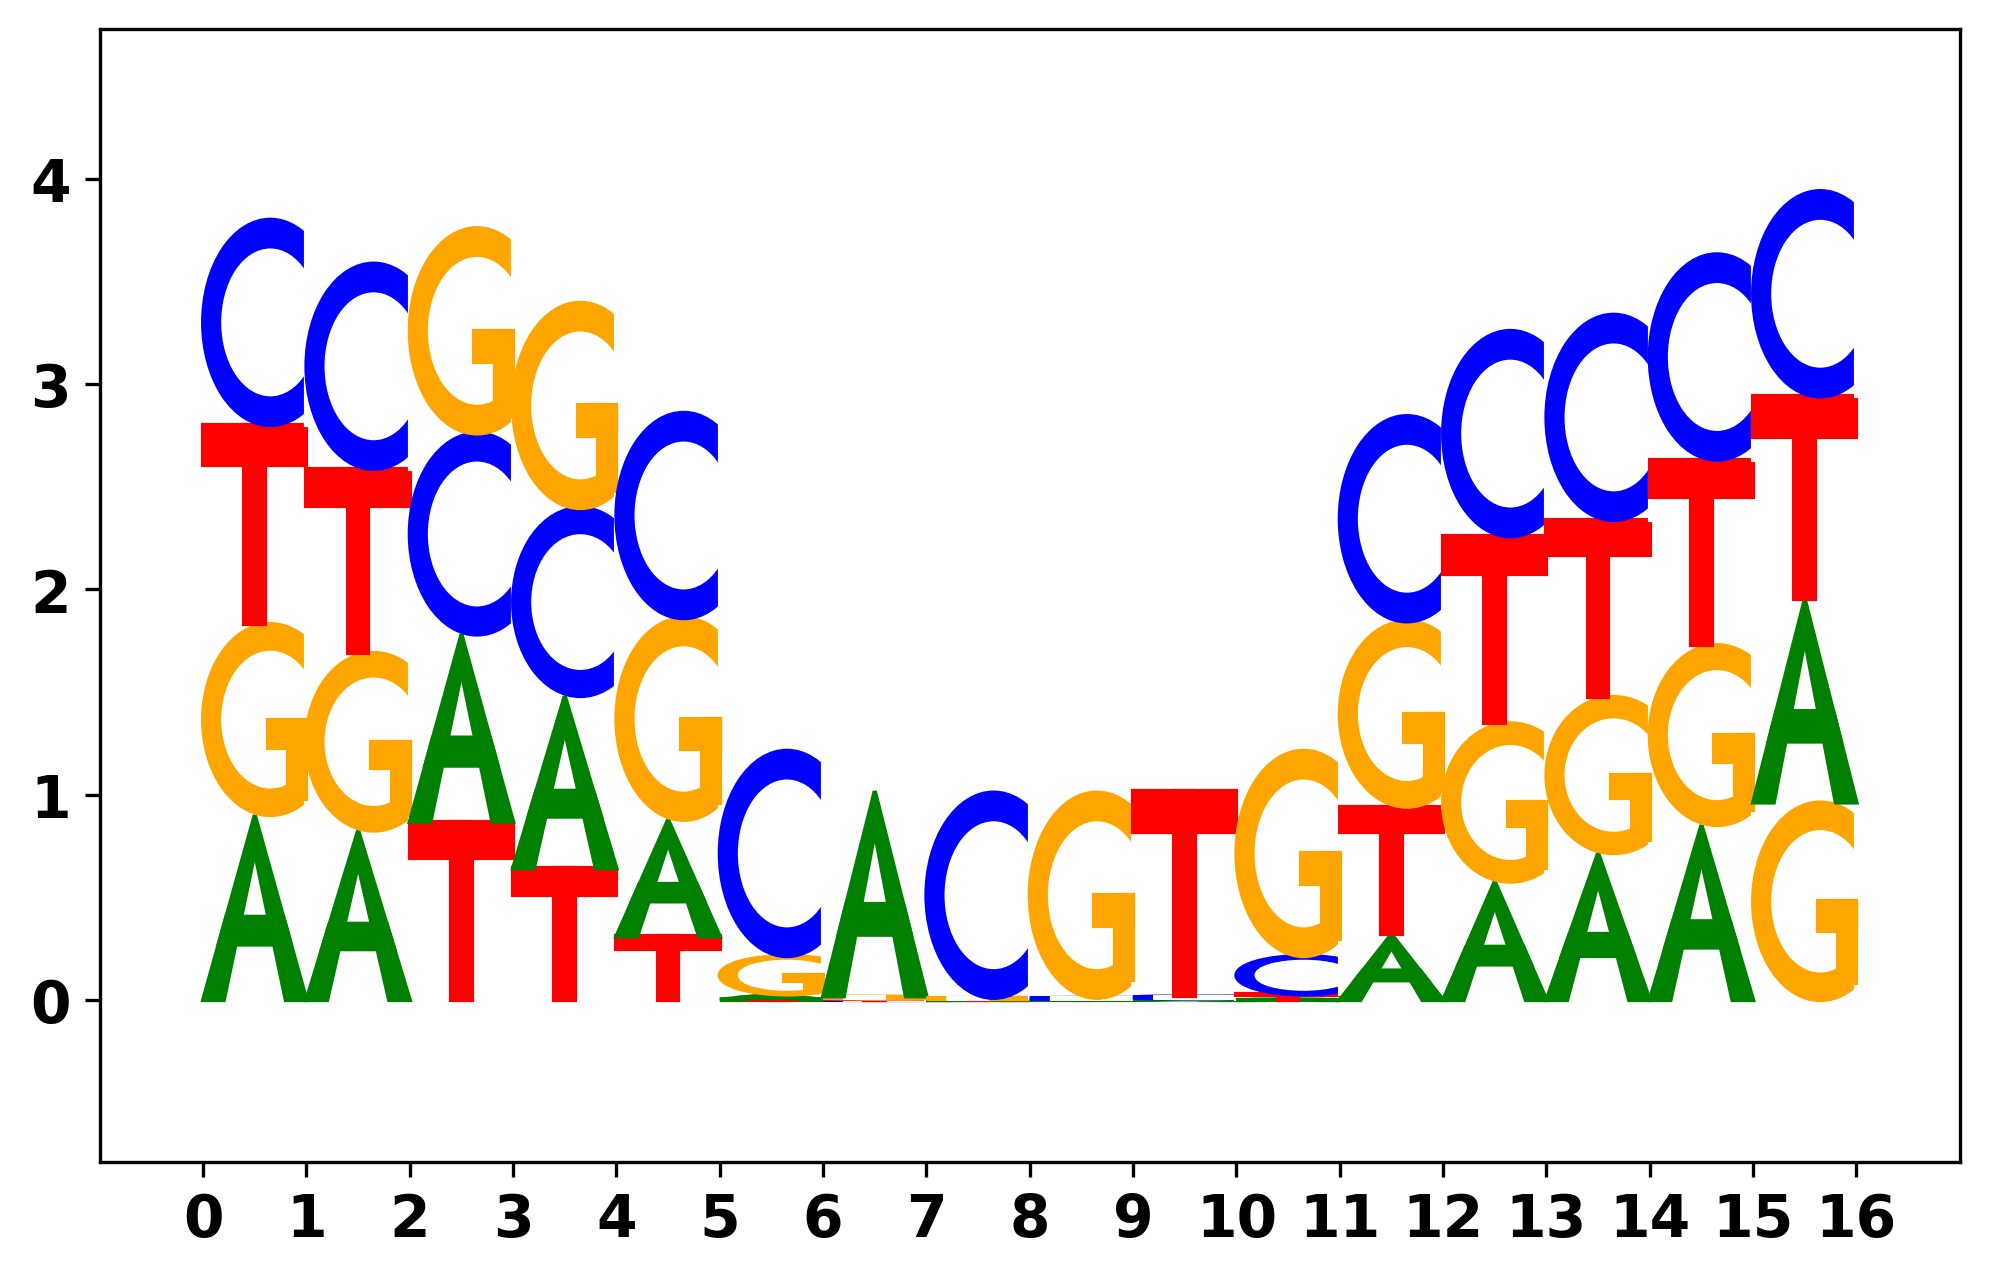

In [8]:
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_PSAM,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

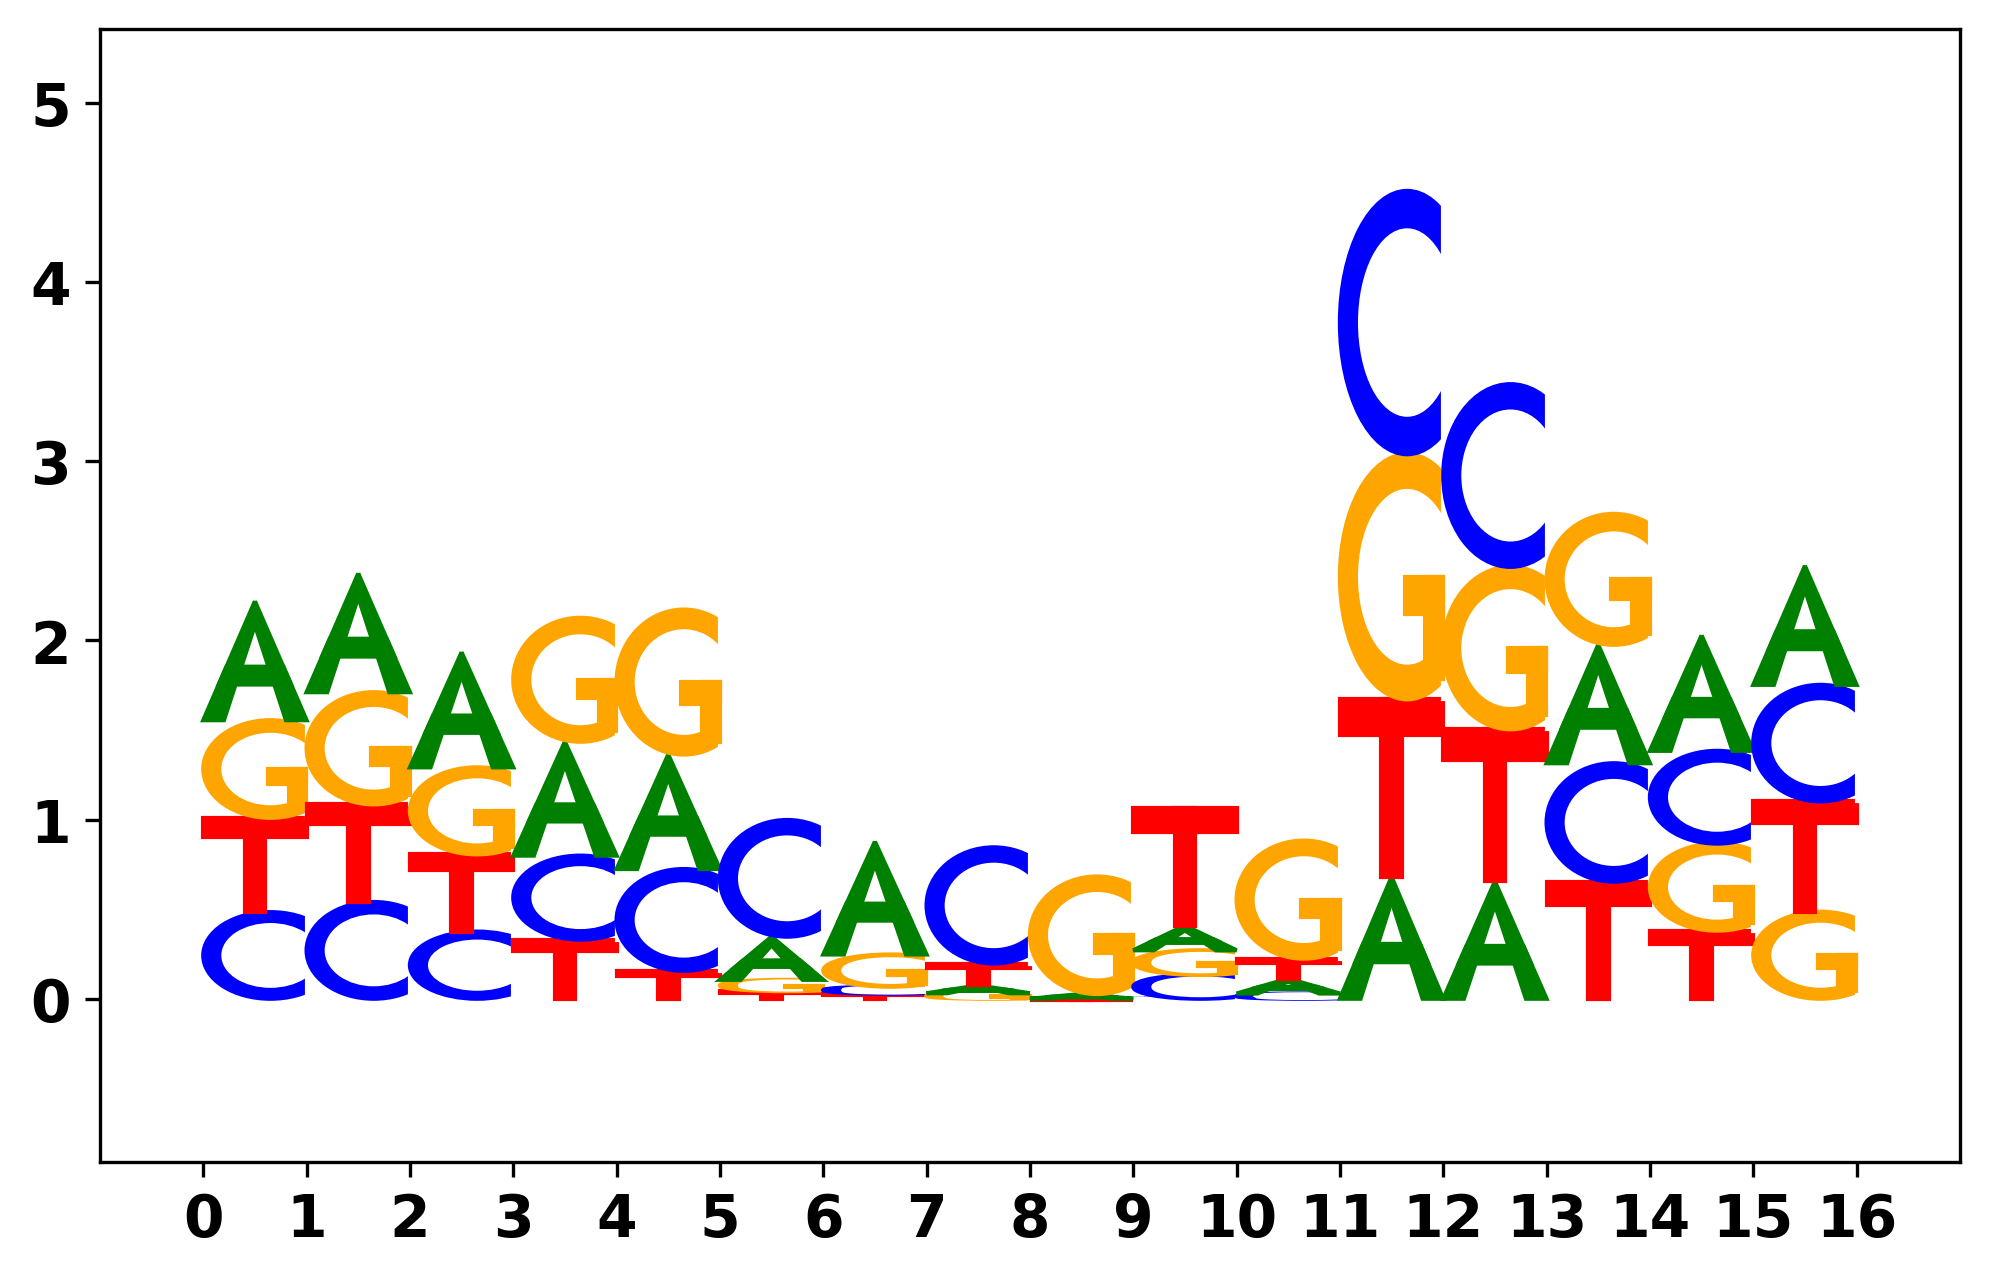

In [9]:
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, distilled_matrix,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

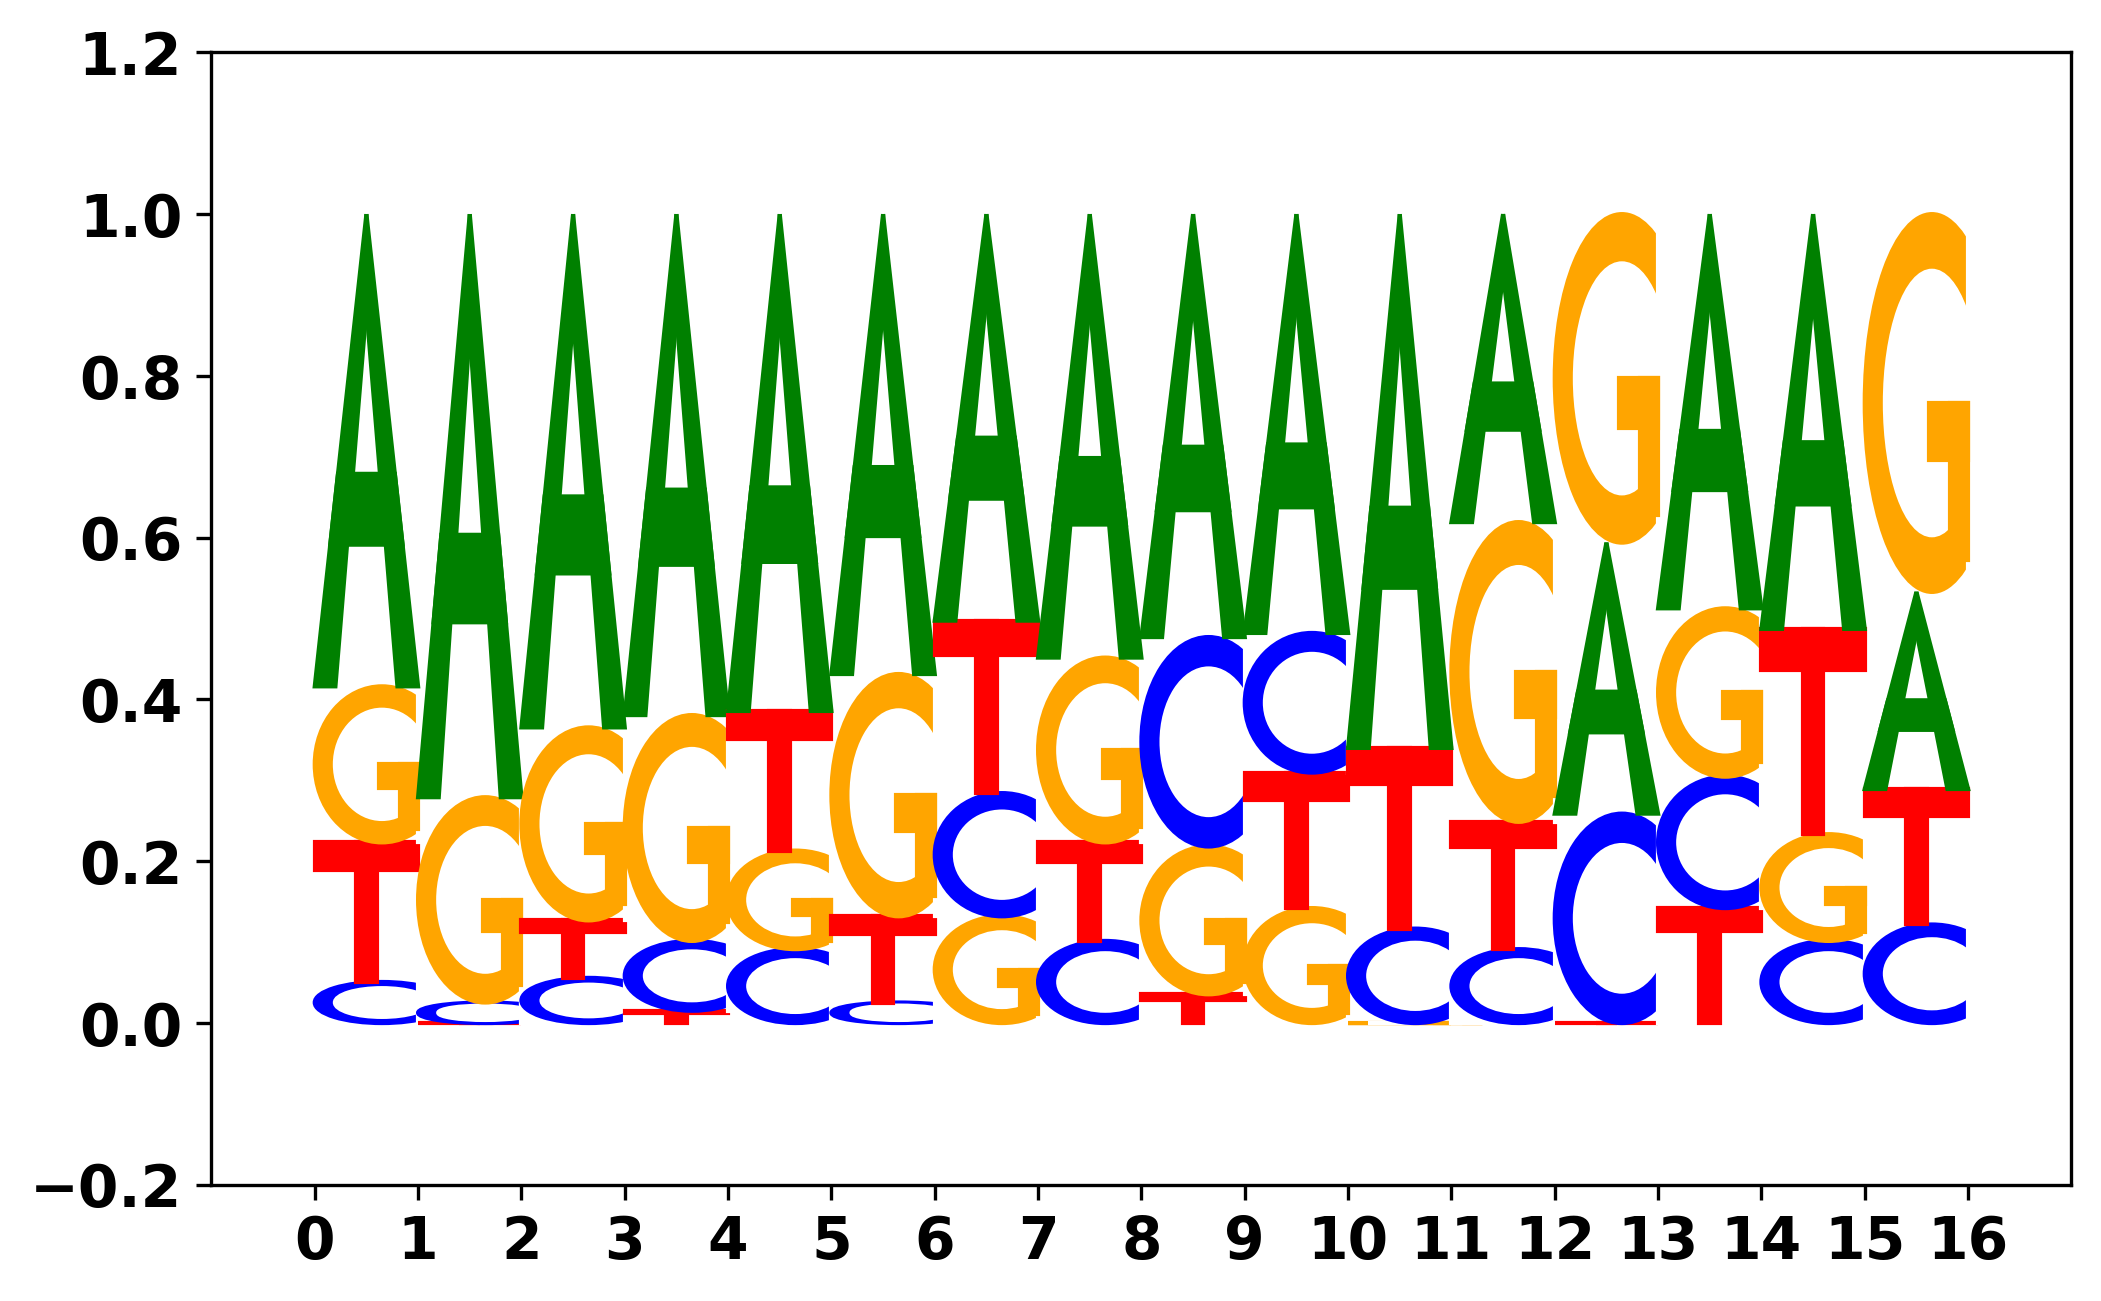

In [10]:
def fileToPSPM(filepath):
    lines = []
    for line in open(filepath):
        lines.append(line.rstrip().split('  '))
    pspm = np.array(lines).astype('float')
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(8,5), dpi=300)
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax, pspm,
                                        height_padding_factor=0.2,
                                        length_padding=1.0,
                                        subticks_frequency=1.0,
                                        highlight={})
    return pspm

ppm = fileToPSPM("/users/amr1/pho4/data/nexus/120min/meme_out_fixed/PSPM.txt")

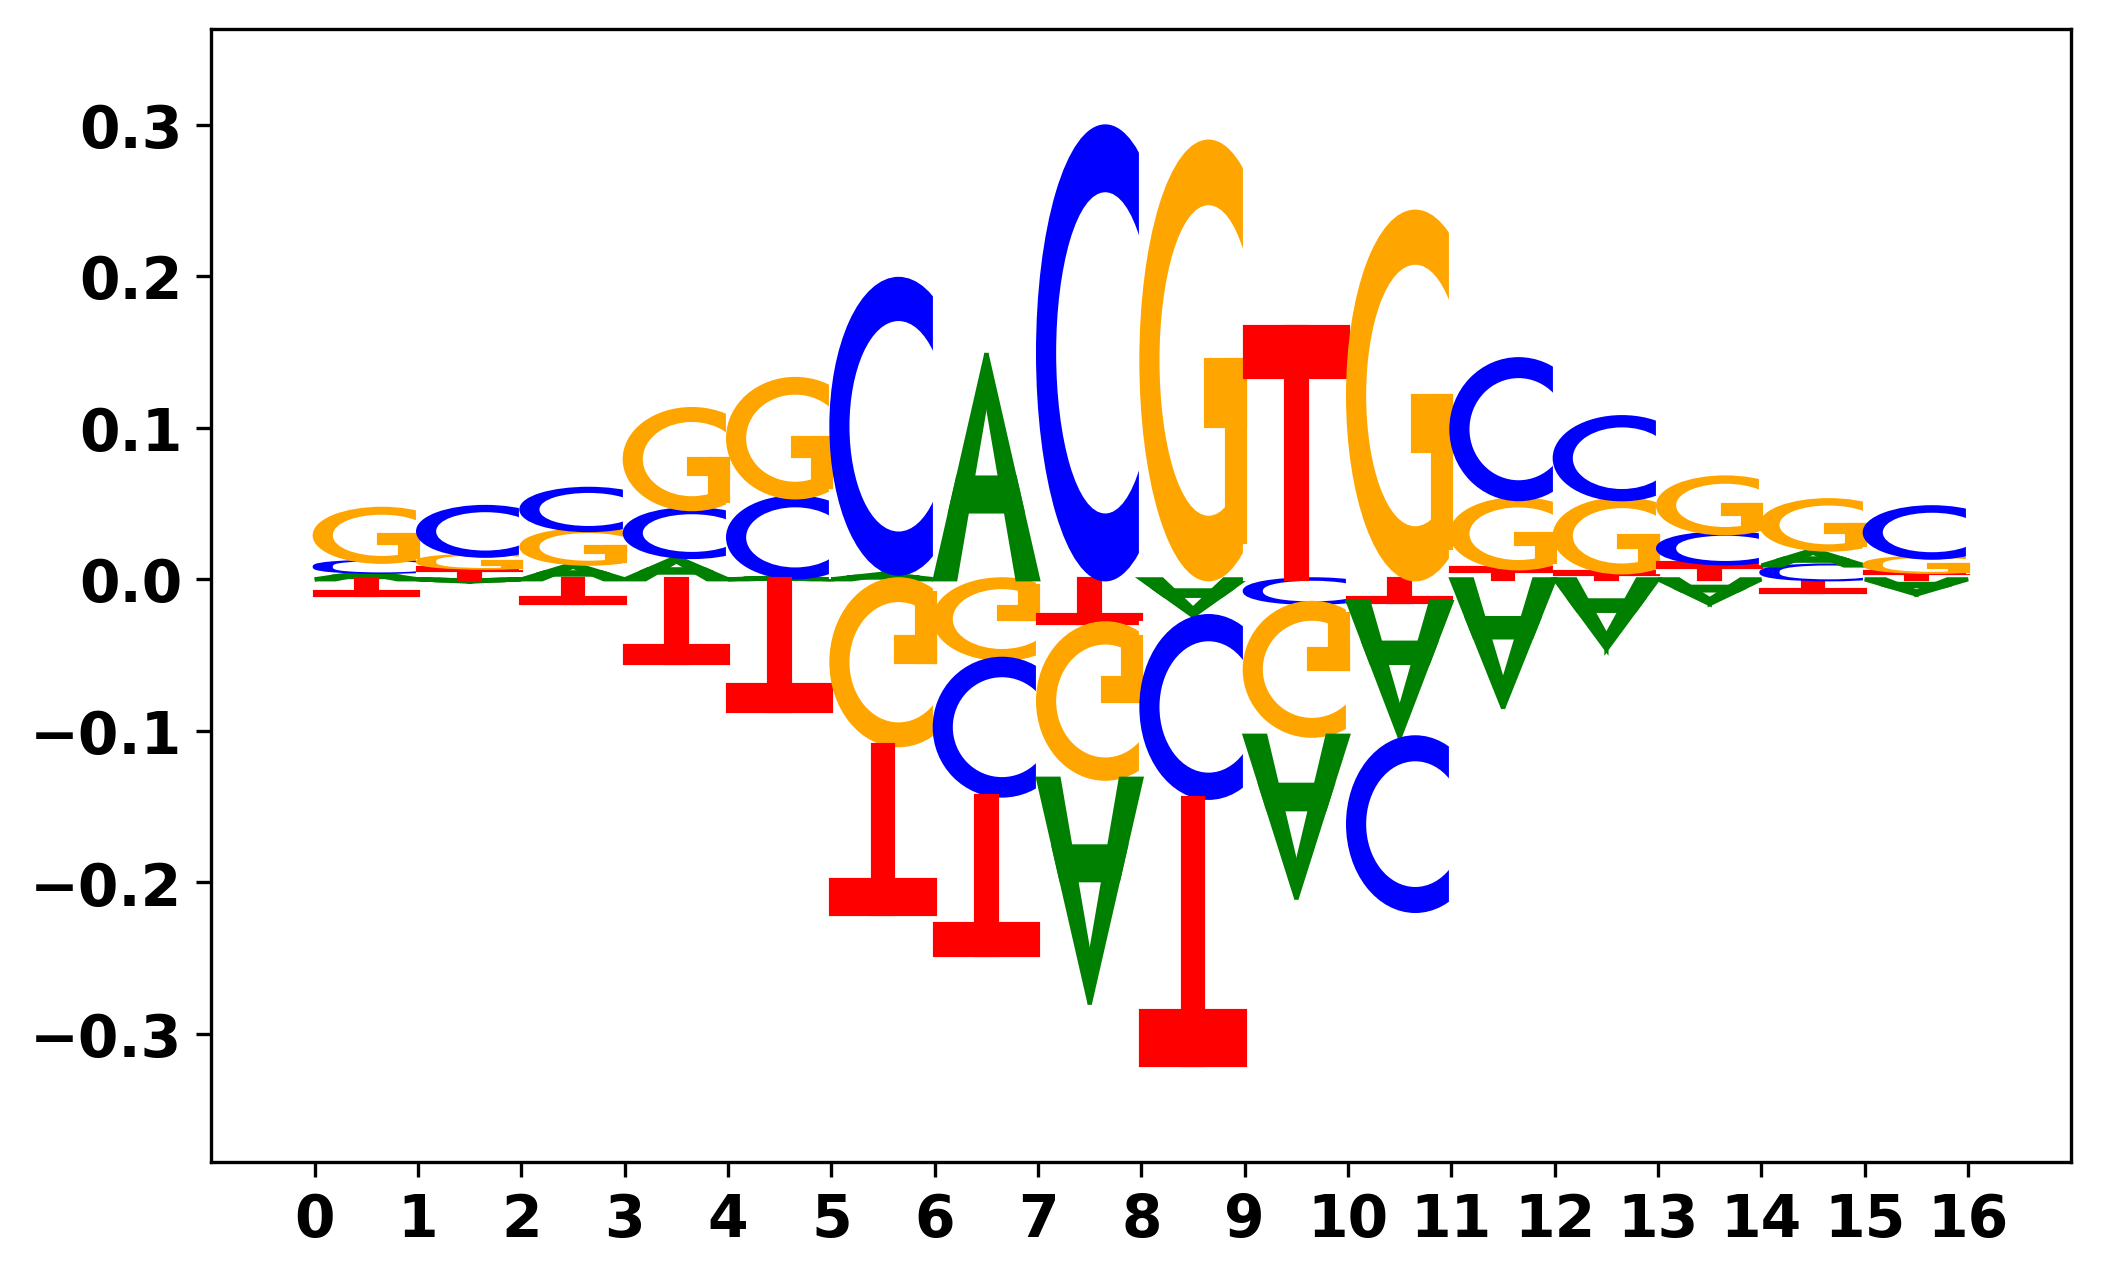

In [11]:
post_hypimps = np.load("/users/amr1/pho4/data/imp-scores/120min_pho4_nexus/post_counts_hypimps.npy")
post_actualimps = np.load("/users/amr1/pho4/data/imp-scores/120min_pho4_nexus/post_counts_actualimps.npy")  
seqs = np.load("/users/amr1/pho4/data/imp-scores/120min_pho4_nexus/seqs.npy")
grp = h5py.File("/users/amr1/pho4/data/modisco/120min_pho4_nexus/counts_results.hdf5","r")

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
            task_names=["task0"], contrib_scores={"task0": post_actualimps},
            hypothetical_contribs={"task0": post_hypimps}, one_hot=seqs)
loaded_tfmodisco_results = workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

modisco_idx = ("metacluster_0", 3, 12, 28)

untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results[modisco_idx[0]]
    .seqlets_to_patterns_result.patterns[modisco_idx[1]])
cwm = untrimmed_pattern["task0_hypothetical_contribs"].fwd[modisco_idx[2]:modisco_idx[3]]

matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, cwm,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

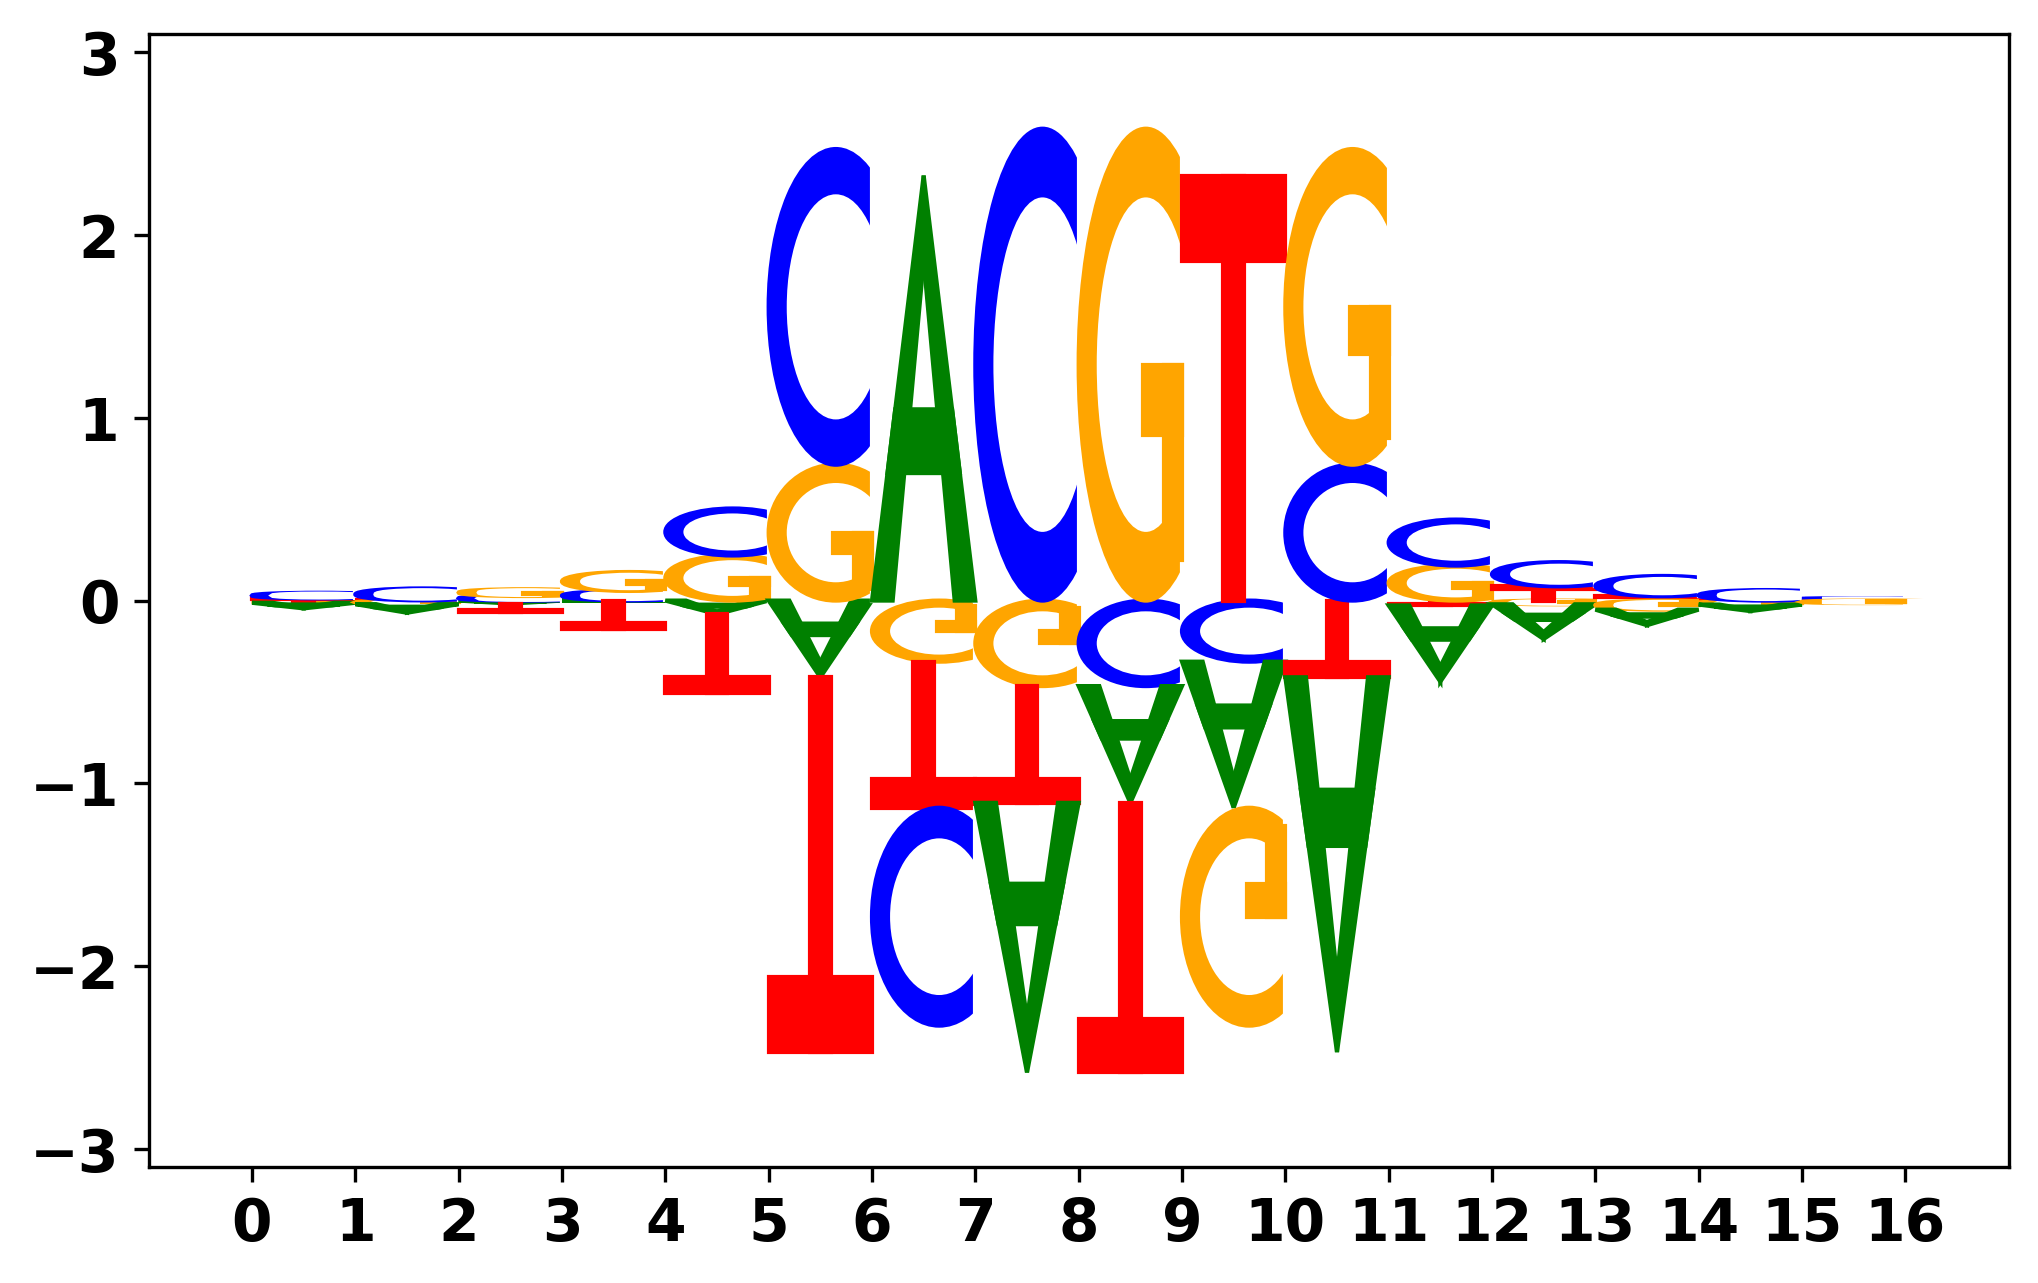

In [12]:
def ddG(Kd1, Kd2, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd2/Kd1)
PHO4_ddG = [[-ddG(x,1) for x in j] for j in PHO4_PSAM]
PHO4_centered_ddG = np.array([i-np.mean(i) for i in PHO4_ddG])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_centered_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

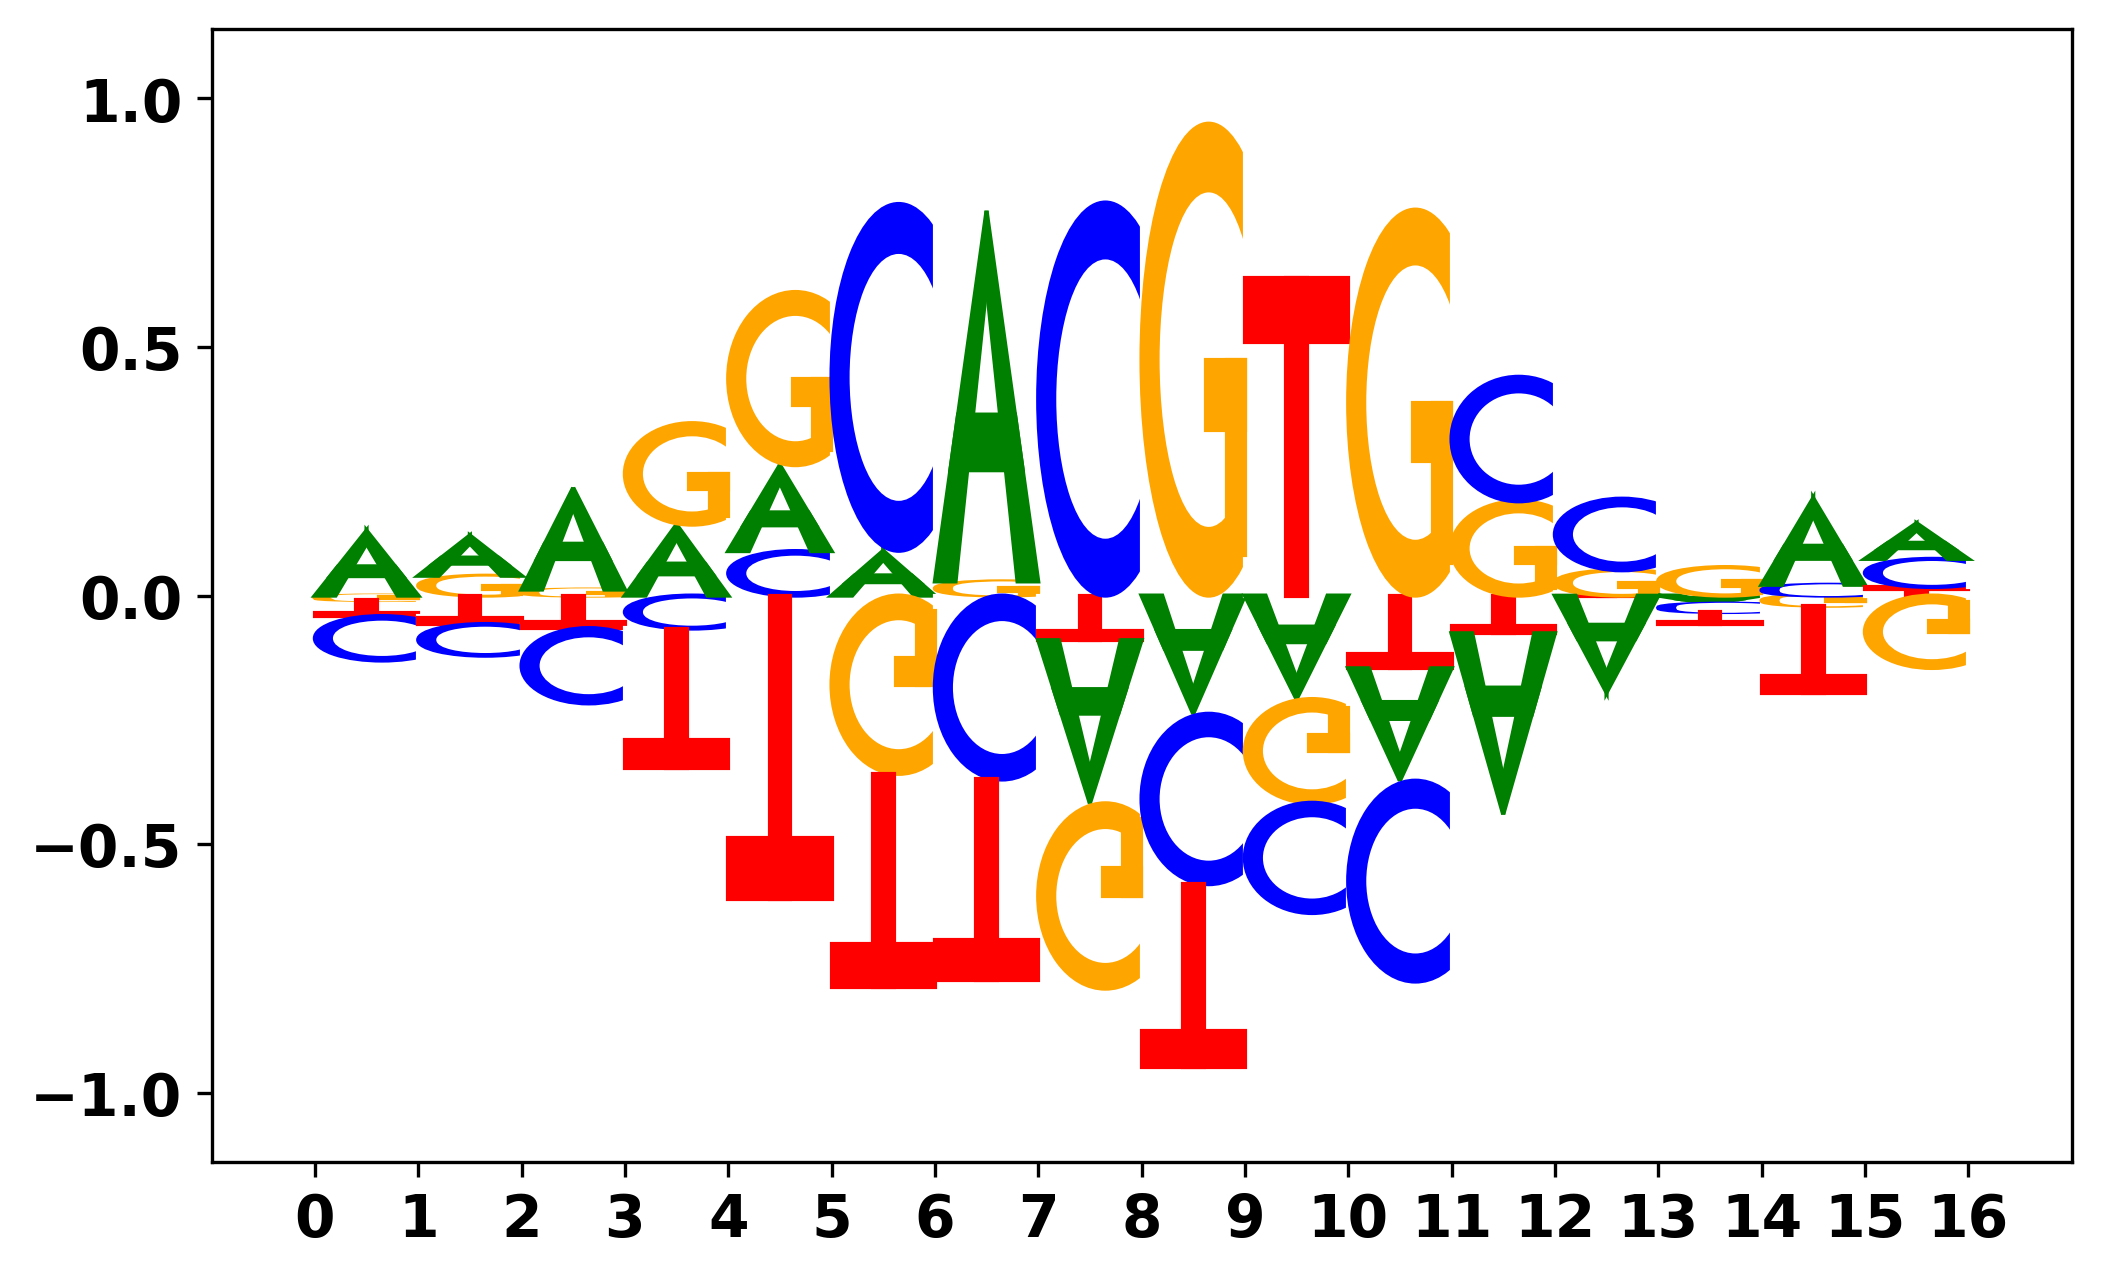

In [13]:
distilled_pwm = np.log((distilled_matrix/0.25)+1)
centered_distilled_pwm = np.array([i-np.mean(i) for i in distilled_pwm])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_distilled_pwm,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

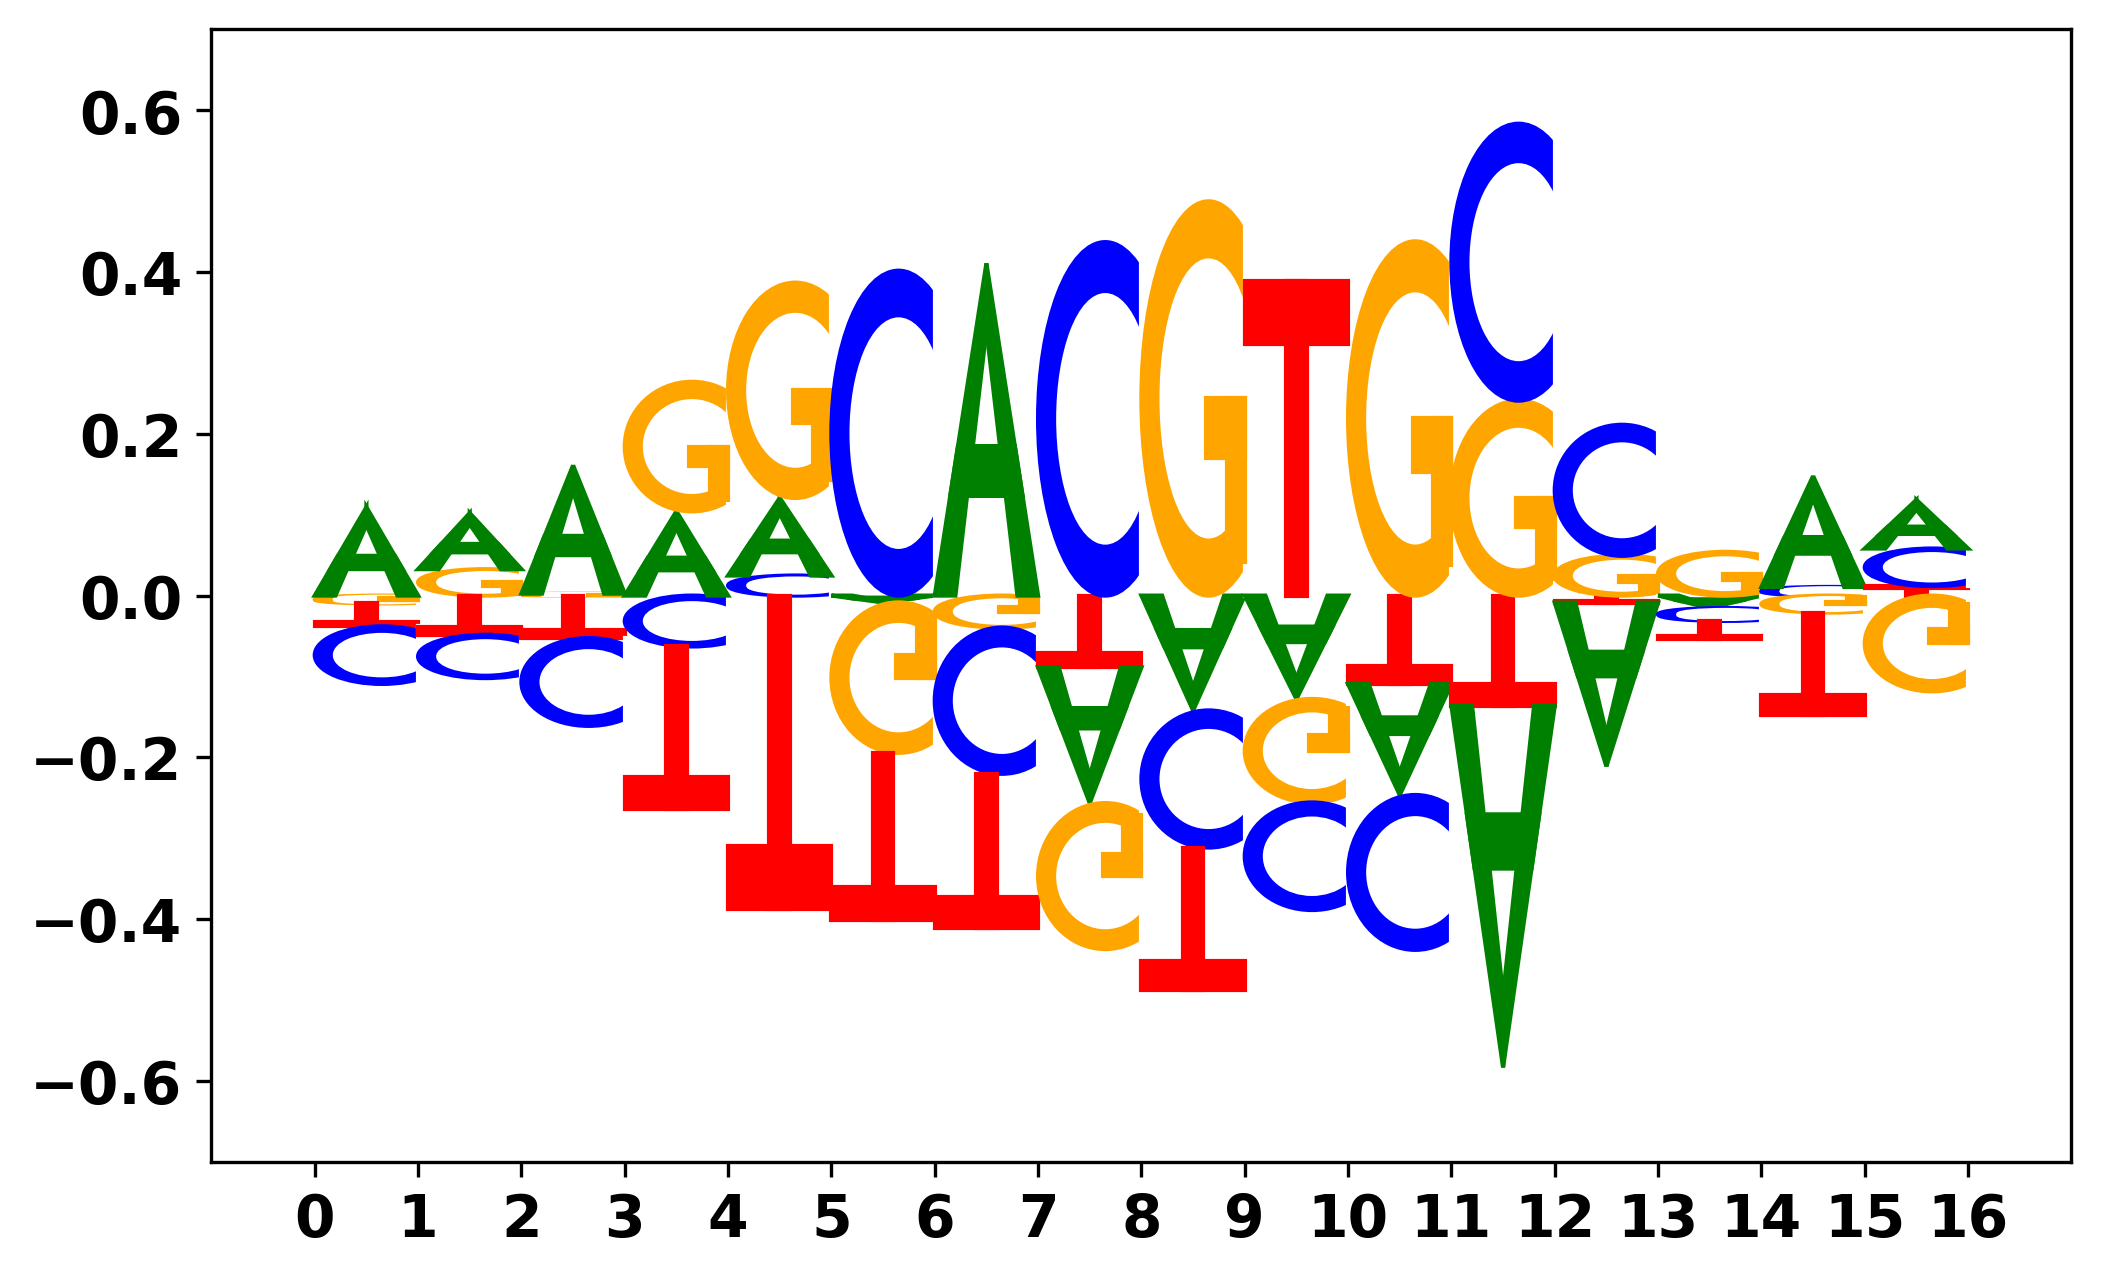

In [14]:
centered_distilled_matrix = np.array([i-np.mean(i) for i in distilled_matrix])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_distilled_matrix,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

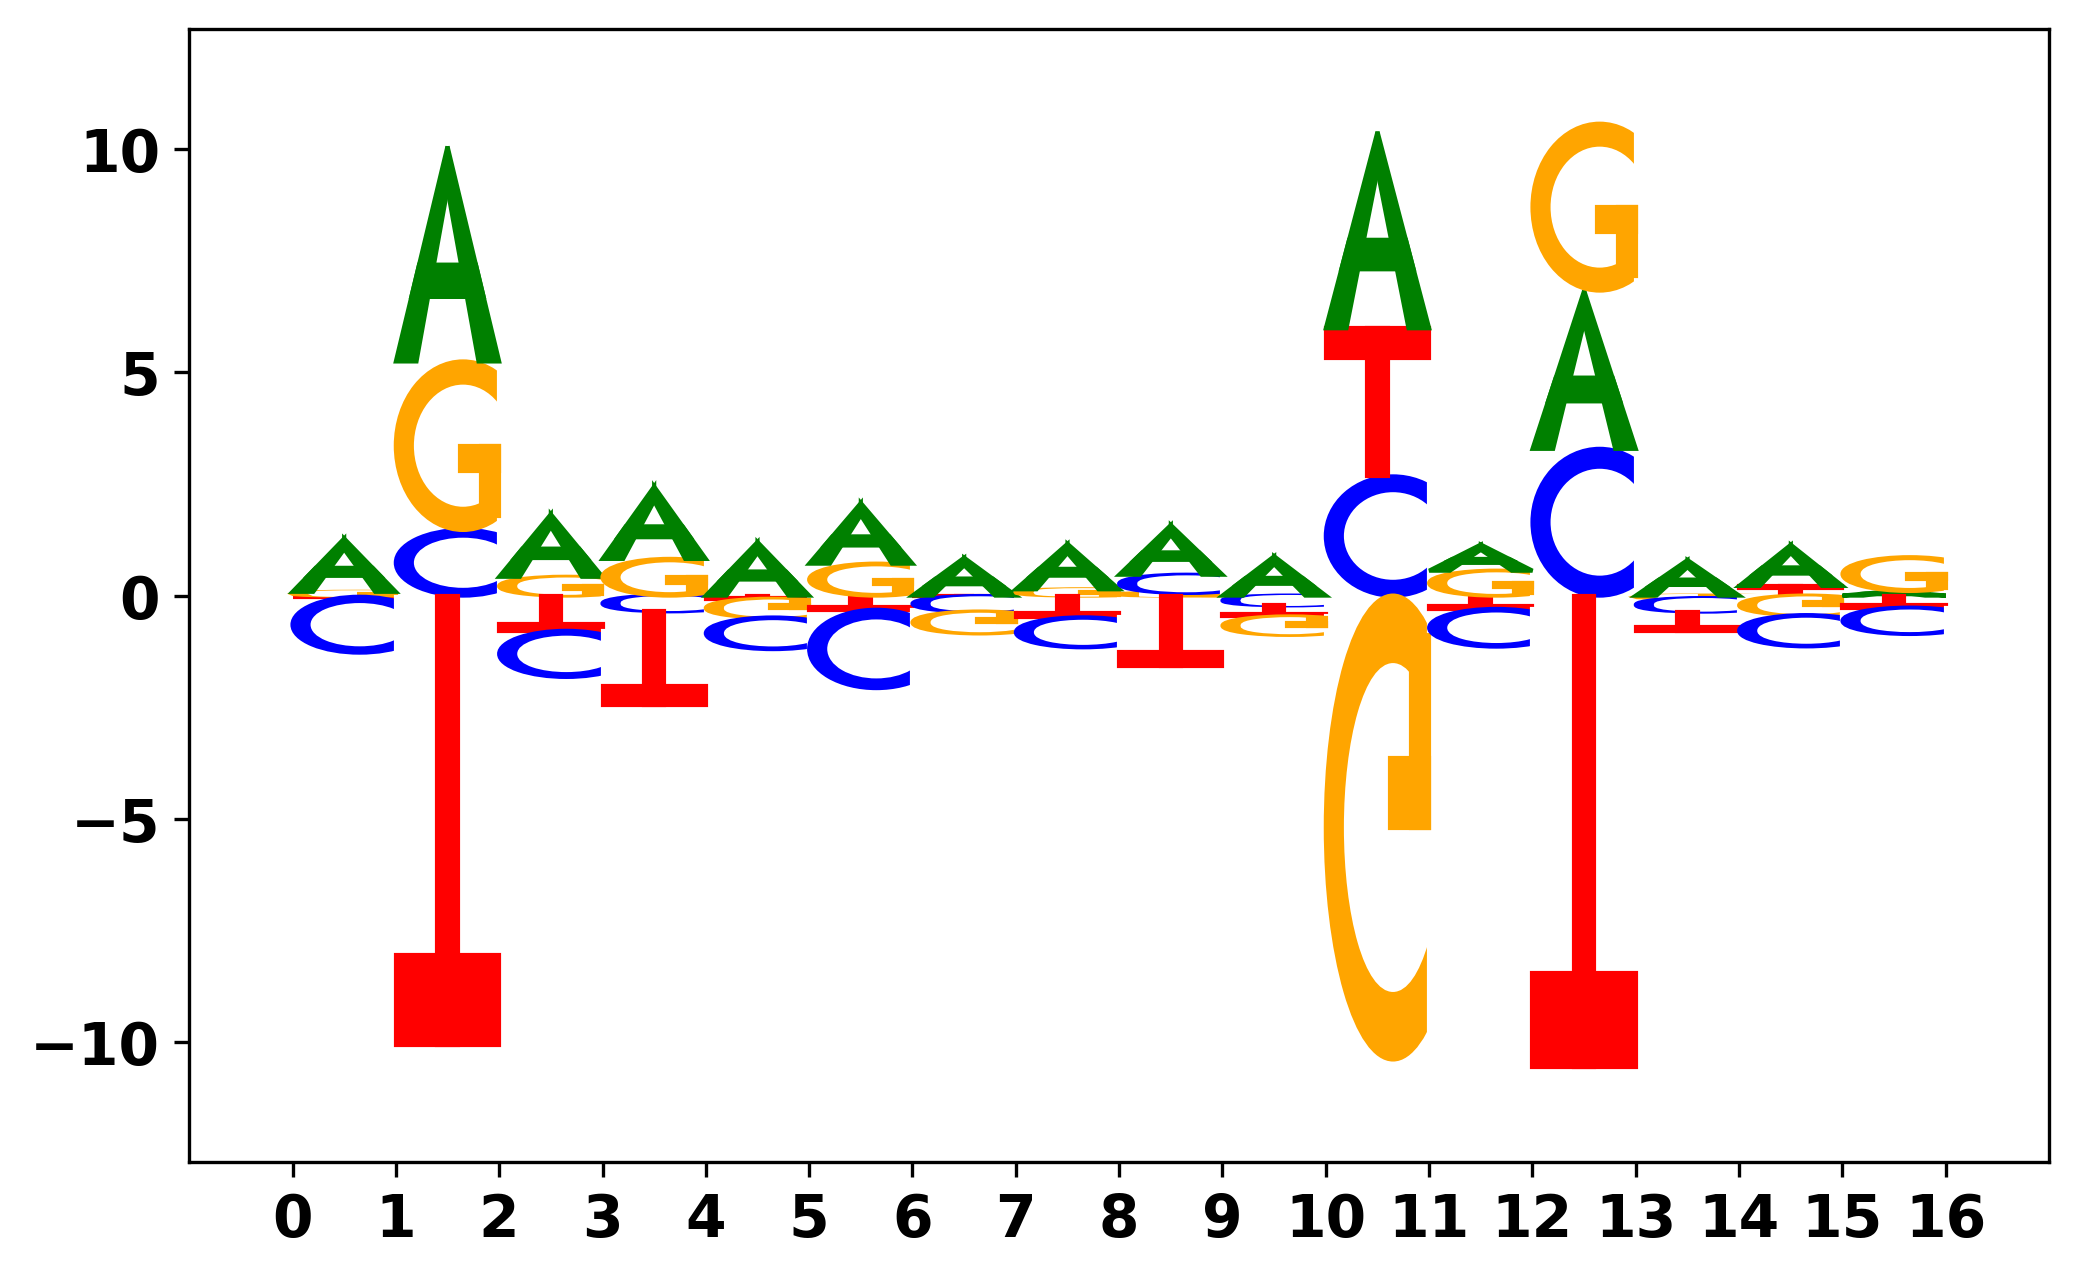

In [15]:
meme_pwm = np.log((ppm/0.25)+1e-6)
centered_meme_pwm = np.array([i-np.mean(i) for i in meme_pwm])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_meme_pwm,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

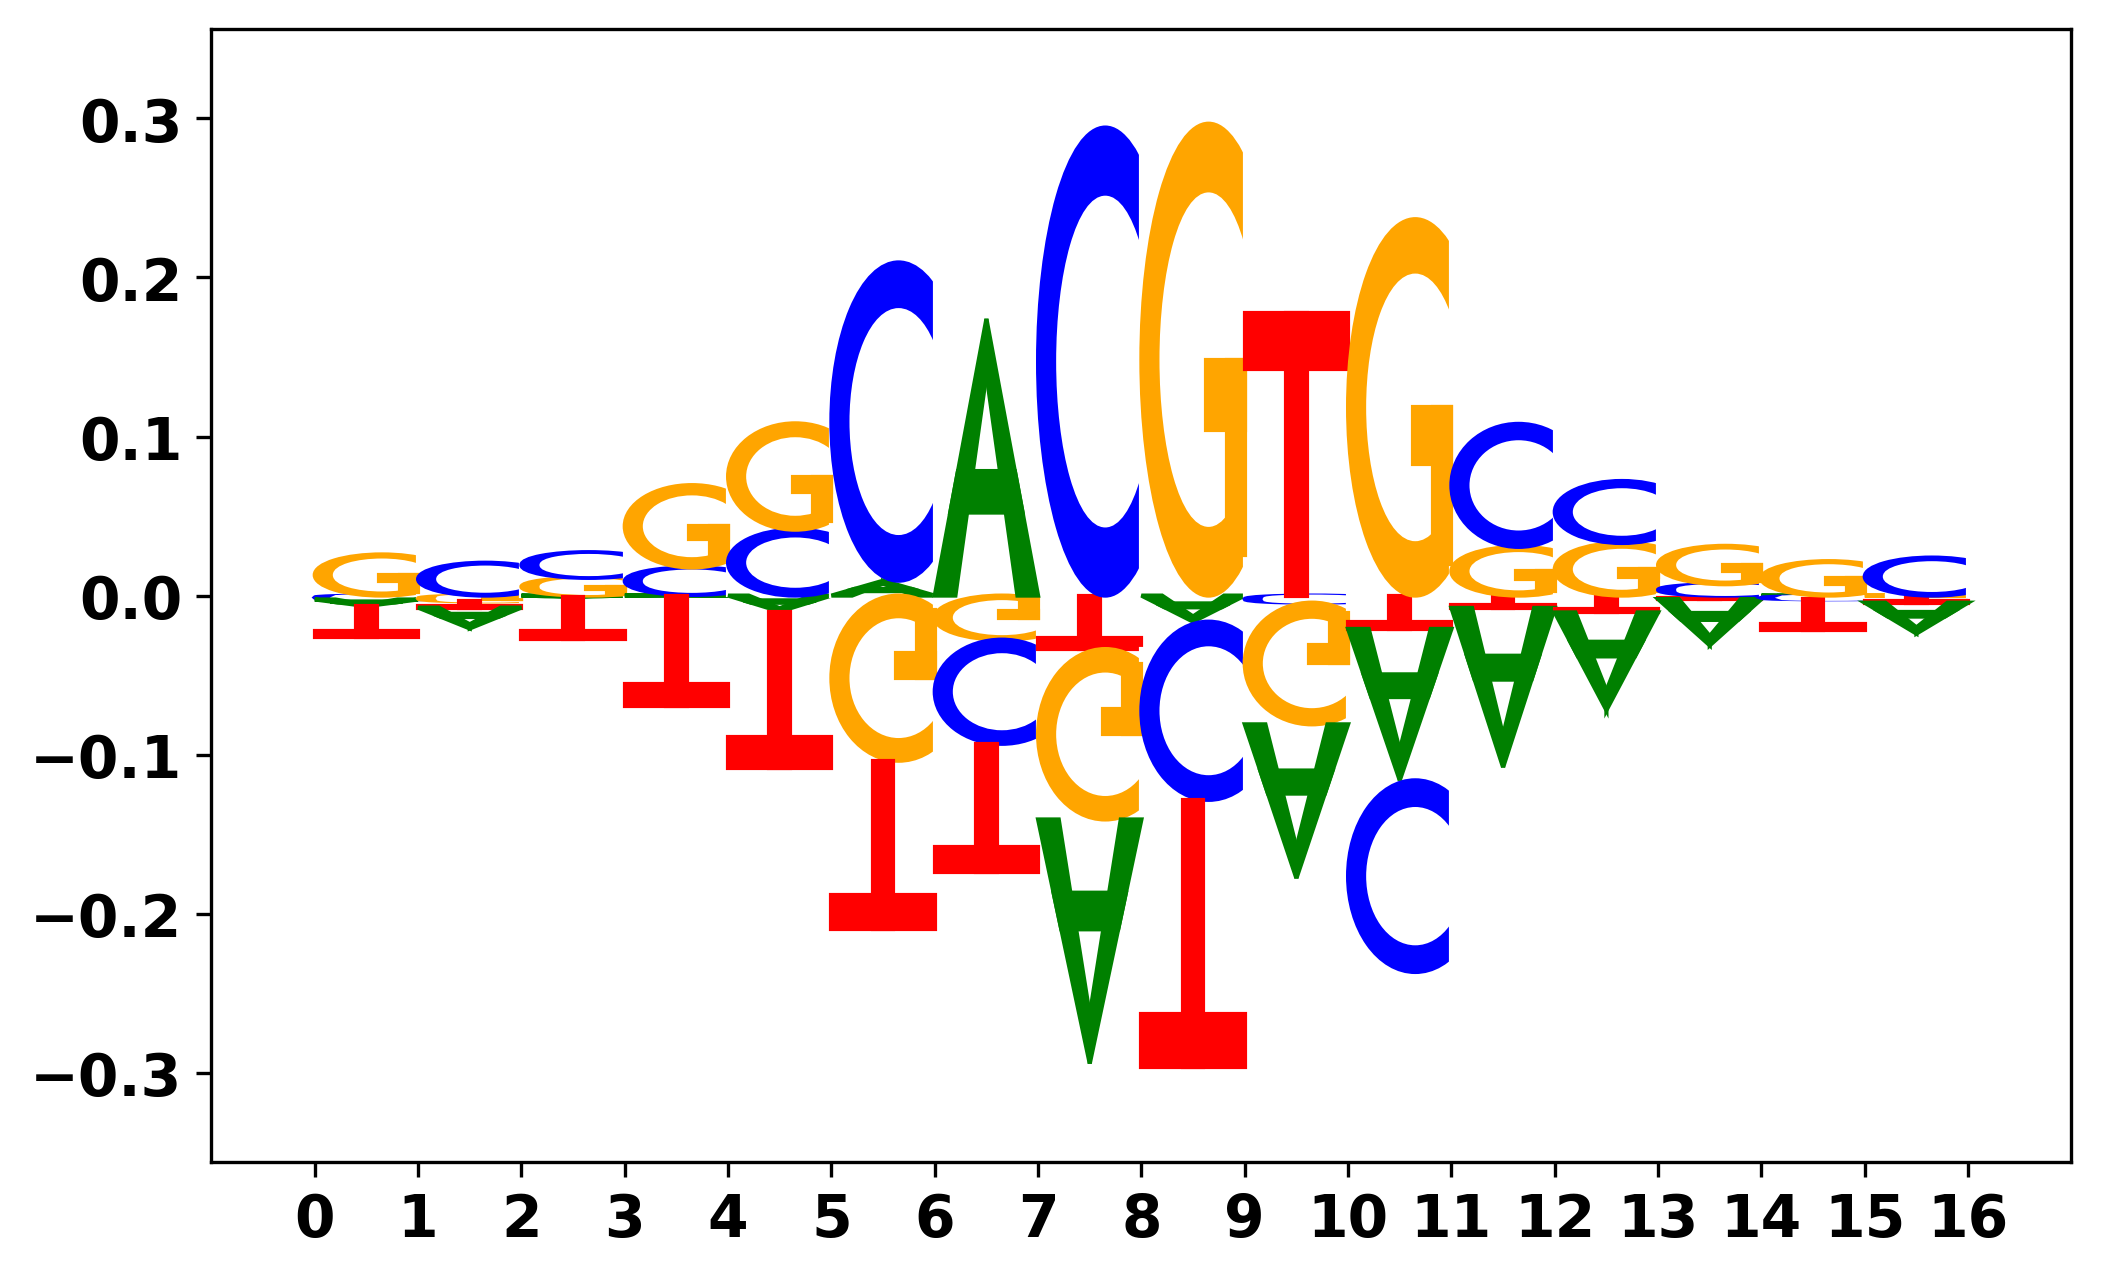

In [16]:
centered_cwm = np.array([i-np.mean(i) for i in cwm])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_cwm,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

[24.105904421429155, 6.501389956542011, 6.037234428099448, 5.273998090106265]


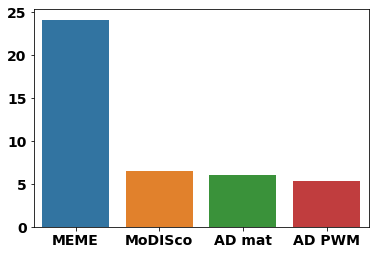

In [17]:
frob_norm = []
for mat in [centered_meme_pwm, centered_cwm, centered_distilled_matrix, centered_distilled_pwm]:
    frob_norm.append(np.linalg.norm(PHO4_centered_ddG-mat, 'fro'))

tips = sns.load_dataset("tips")
ax = sns.barplot(x=["MEME", "MoDISco", "AD mat", "AD PWM"], y=frob_norm)
print(frob_norm)

[1.5466468388228607, 0.5390383941779834, 0.7068132677055091, 0.609023497583204]


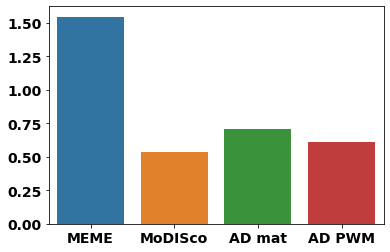

In [18]:
PHO4_ddG_normalized = PHO4_centered_ddG/np.linalg.norm(PHO4_centered_ddG, 'fro')

frob_norm = []
for mat in [centered_meme_pwm, centered_cwm, centered_distilled_matrix, centered_distilled_pwm]:
    mat_normalized = mat/np.linalg.norm(mat, 'fro')
    frob_norm.append(np.linalg.norm(PHO4_ddG_normalized-mat_normalized, 'fro'))

tips = sns.load_dataset("tips")
ax = sns.barplot(x=["MEME", "MoDISco", "AD mat", "AD PWM"], y=frob_norm)
print(frob_norm)

[1.196058222020374, 0.14528119519898952, 0.24979249770226986, 0.1854548103042395]


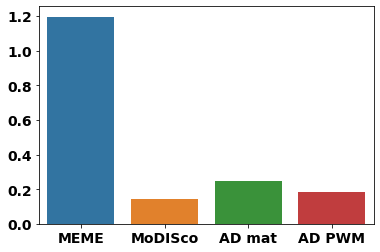

In [19]:
import scipy.spatial as sp

cos_dists = []
for mat in [centered_meme_pwm, centered_cwm, centered_distilled_matrix, centered_distilled_pwm]:
    cos_dists.append(sp.distance.cosine(PHO4_centered_ddG.flatten(), mat.flatten()))

tips = sns.load_dataset("tips")
ax = sns.barplot(x=["MEME", "MoDISco", "AD mat", "AD PWM"], y=cos_dists)
print(cos_dists)

[1.196058222020374, 0.14528119519898952, 0.24979249770226986, 0.18545481030423938]


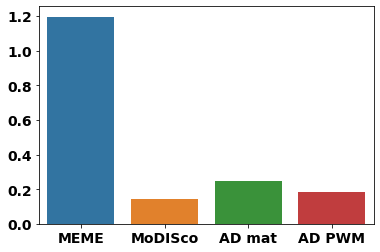

In [20]:
corr_dists = []
for mat in [centered_meme_pwm, centered_cwm, centered_distilled_matrix, centered_distilled_pwm]:
    corr_dists.append(sp.distance.correlation(PHO4_centered_ddG.flatten(), mat.flatten()))

tips = sns.load_dataset("tips")
ax = sns.barplot(x=["MEME", "MoDISco", "AD mat", "AD PWM"], y=corr_dists)
print(corr_dists)